In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import scienceplots

In [2]:
rootdir = '/home/gayatri/Documents/cloudy_scripts/blr/grids/'

In [3]:
plt.style.use(['science', 'notebook', 'no-latex'])
plt.rcParams.update({
    # "font.family": "serif",   # specify font family here
    # "font.serif": ["Times"],  # specify font here
    "font.size":12}) 

## Fetch the SED at $z=0.226$.

In [4]:
hm12_z_grid, hm12_wav_grid, hm12_J_nu_grid = read_uvb('', 'hm12_galaxy.ascii')
z_test = 0.226
hm12_J_nu_test = fetch_sed(z_test, hm12_z_grid, hm12_J_nu_grid)

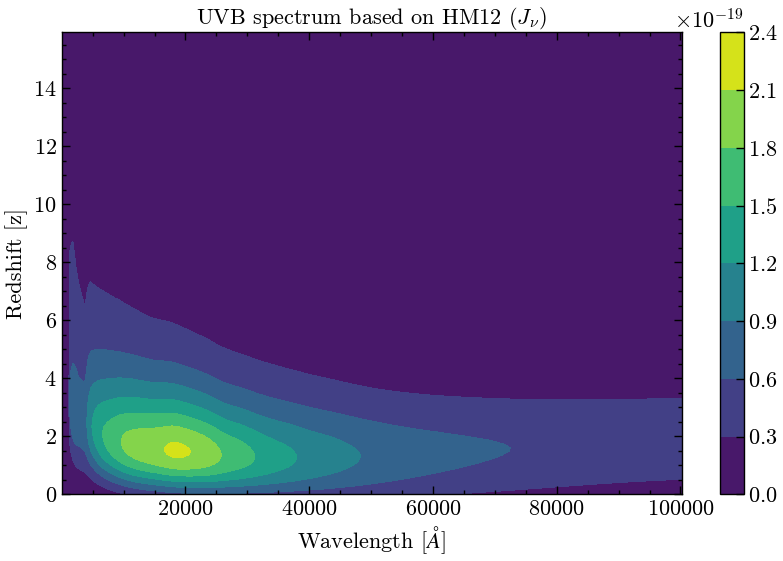

In [5]:
[X, Y] = np.meshgrid(hm12_wav_grid, hm12_z_grid)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
img = plt.contourf(X, Y, hm12_J_nu_grid)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Redshift [z]')
plt.title(r'UVB spectrum based on HM12 ($J_\nu$)')
plt.colorbar(img)
plt.show()

Text(0.5, 1.0, 'UVB spectrum based on HM12 (at $z = 0.226$)')

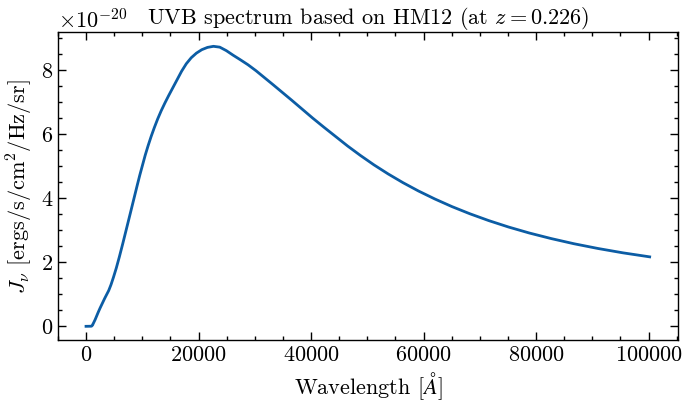

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.plot(hm12_wav_grid, hm12_J_nu_test)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'$J_\nu$ [ergs/s/cm$^2$/Hz/sr]')
plt.title(f'UVB spectrum based on HM12 (at $z = {z_test}$)')

## plotting

In [7]:
logN_HI_min = 12
logN_HI_max = 12.25
logN_HI_step = 0.25

logN_HI_arr = np.array([12, 12.25, 13, 16]) #np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

file_list = create_grid_file_list(logN_HI_arr)

# Specify grid points for densities and metallicities
log_hdens_min = -4.25
log_hdens_max = 1
log_hdens_step = 0.25
log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, 10**log_hdens_arr))

log_metals_min = -0.25
log_metals_max = 1
log_metals_step = 0.25
log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Fetch $\log N$ for each species, and iterpolate the grid points.

In [9]:
pkl_file = open(rootdir+'1600_final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

In [10]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

Calculate $\log U$ from $n_\text{HI}$.

Text(0, 0.5, 'log $U$')

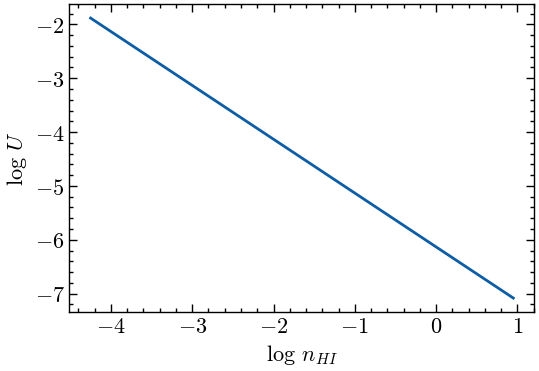

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
log_hdens_plot = np.arange(log_hdens_min, log_hdens_max+.01, .1)
logU_plot = np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, 10**log_hdens_plot))
plt.plot(log_hdens_plot, logU_plot)
plt.xlabel('log $n_{HI}$')
plt.ylabel('log $U$')

Consider a particular $N_\text{HI} = 13$ and metallicity 0.

In [12]:
logN_HI_test = 16
log_m_test = 0
plot_points = [[logN_HI_test, np.round(log_hdens,2), log_m_test] for log_hdens in log_hdens_plot]
logN_HI_idx = np.where(logN_HI_arr==logN_HI_test)[0][0]
log_m_idx = np.where(log_metals_arr==log_m_test)[0][0]

/home/gayatri/miniconda3/envs/tardis/lib/python3.11/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


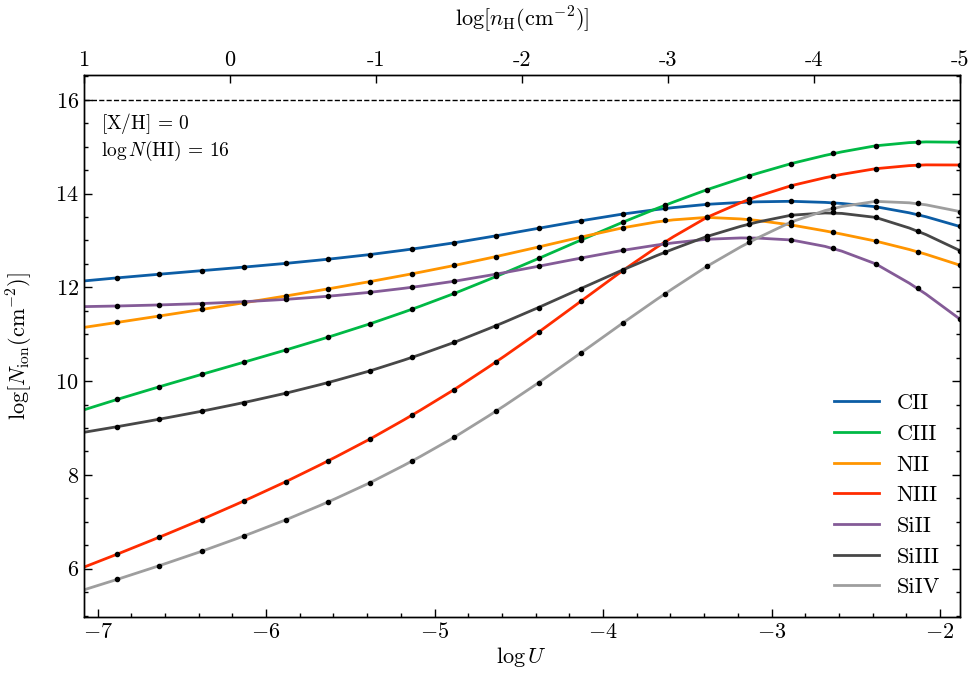

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
  
ax.text(x=0.02,y=0.9,s=r'$\mathrm{[X/H]}$ = ' + '{}'.format(log_m_test), fontsize=14, transform=ax.transAxes)
ax.text(x=0.02,y=0.85,s=r'$\log N$(HI) = ' + '{}'.format(logN_HI_test), fontsize=14, transform=ax.transAxes)
ax.axhline(logN_HI_test, linestyle='--', lw=1, color='k')

# Plot column densities
species = ['CII', 'CIII', 'NII', 'NIII', "SiII", 'SiIII', 'SiIV']
for s in species:
    ax.plot(logU_plot, species_logN_interp[ion_species_dict[s]](plot_points), label=s)
    ax.plot(logU_arr, species_logN_samples[ion_species_dict[s]][logN_HI_idx,:,log_m_idx], marker='.', linestyle='', color='k')

ax.set_xlim(logU_plot[-1], logU_plot[0])
ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
new_ticks = np.arange(-5,2,1, dtype='float')
ax_copy.set_xlim(ax.get_xlim())
ax_copy.set_xticks(np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, np.power(10, new_ticks))))
ax_copy.set_xticklabels(np.int_(new_ticks))

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel(r'$\log U$', labelpad=20)
ax_label.set_ylabel(r'$\log [N_{\mathrm{ion}} (\mathrm{cm}^{-2})]$', labelpad=35)

ax_copy_label = fig.add_subplot(111, frameon=False)
ax_copy_label.set_xticks([])
ax_copy_label.set_yticks([])
ax_copy_label.set_xlabel(r'$\log [n_\mathrm{H} (\mathrm{cm}^{-2})]$', labelpad=35)
ax_copy_label.xaxis.set_label_position('top')

ax.legend()
plt.tight_layout()
# plt.show()

## tests

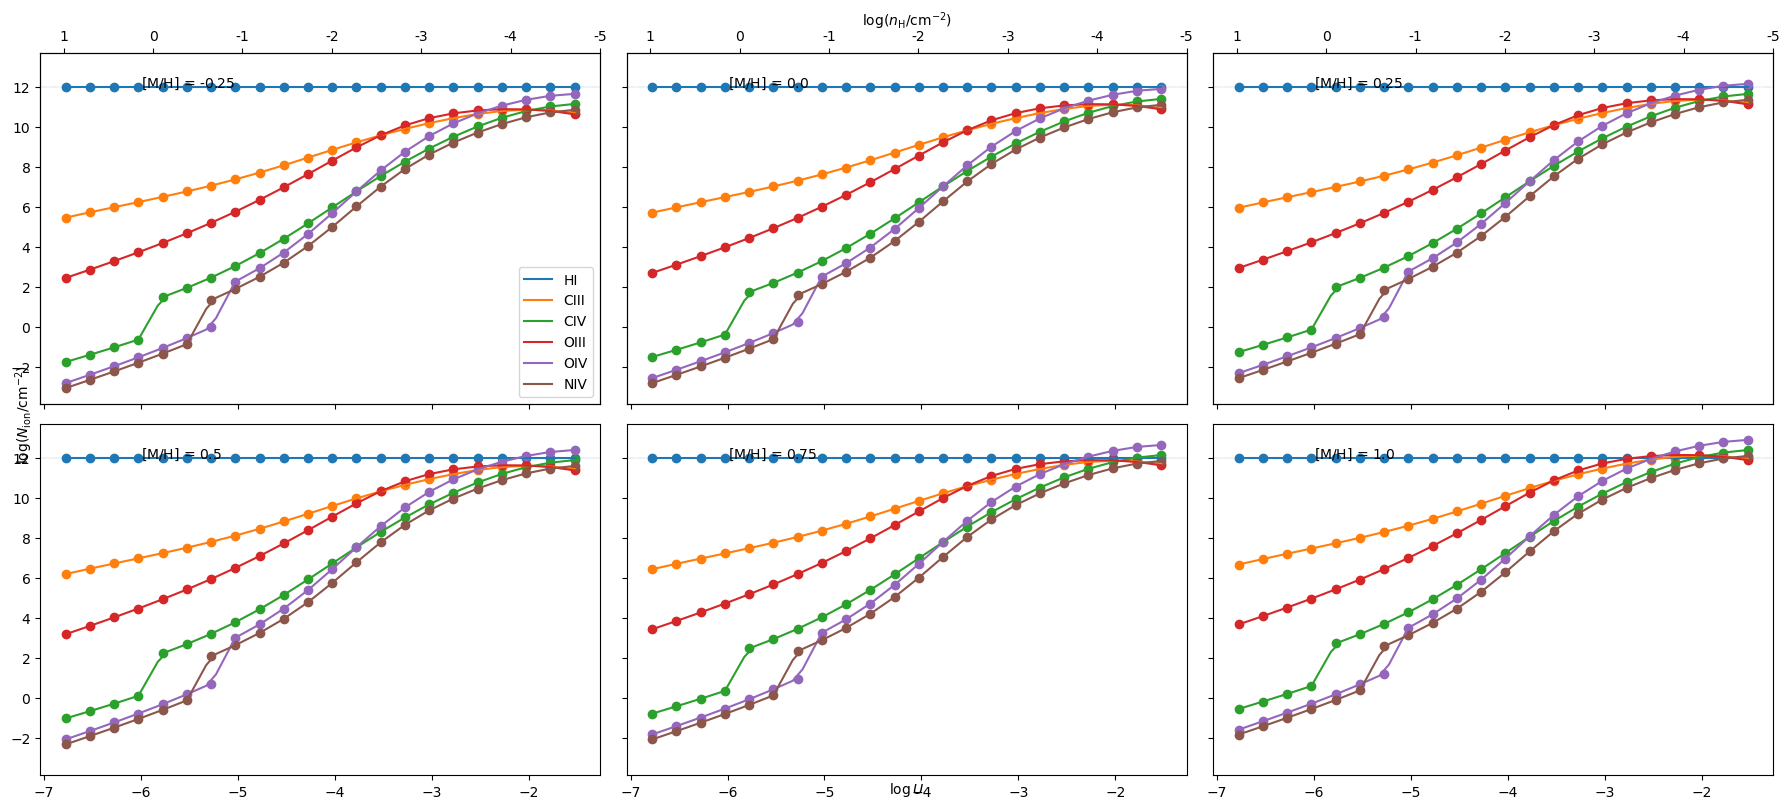

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(6*3,4*2), sharex=True, sharey=True)
for i in range(len(plot_log_metals)):
    
    log_m = plot_log_metals[i]
    log_m_idx = np.where(log_metals_arr==log_m)[0][0]
        
    ax = axes[i//3, i%3]
    
    ax.text(x=-6,y=12,s=r'$\mathrm{[M/H]}$ = ' + '{}'.format(log_m))
    
    # Reference line
    ax.axhline(logN_HI_test, linestyle=':', lw=.3)
    
    # Plotting points
    plot_points = [[logN_HI_test, log_hdens, log_m] for log_hdens in log_hdens_plot][:-1]
    # print(plot_points)
    
    # Plot sampled column densities
    ax.scatter(logU_arr, species_logN_samples['#column density H'][logN_HI_idx,:,log_m_idx])
    ax.scatter(logU_arr, species_logN_samples['C+2'][logN_HI_idx,:,log_m_idx])
    ax.scatter(logU_arr, species_logN_samples['C+3'][logN_HI_idx,:,log_m_idx])
    ax.scatter(logU_arr, species_logN_samples['O+2'][logN_HI_idx,:,log_m_idx])
    ax.scatter(logU_arr, species_logN_samples['O+3'][logN_HI_idx,:,log_m_idx])
    ax.scatter(logU_arr, species_logN_samples['N+3'][logN_HI_idx,:,log_m_idx])
    
    # Plot interpolated column densities
    ax.plot(logU_plot, species_logN_interp['#column density H'](plot_points), label='HI')
    ax.plot(logU_plot, species_logN_interp['C+2'](plot_points), label='CIII')
    ax.plot(logU_plot, species_logN_interp['C+3'](plot_points), label='CIV')
    ax.plot(logU_plot, species_logN_interp['O+2'](plot_points), label='OIII')
    ax.plot(logU_plot, species_logN_interp['O+3'](plot_points), label='OIV')
    ax.plot(logU_plot, species_logN_interp['N+3'](plot_points), label='NIV')
    
    # ax.set_ylim(2,17.5)

    if i//3 == 0:
        ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
        new_ticks = np.arange(-5,2,1, dtype='float')
        ax_copy.set_xlim(ax.get_xlim())
        ax_copy.set_xticks(np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, np.power(10, new_ticks))))
        ax_copy.set_xticklabels(np.int_(new_ticks))
    
    if i==0:
        ax.legend(loc='lower right')

plt.tight_layout()

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel(r'$\log U$')
ax_label.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^{-2})$')

ax_copy_label = fig.add_subplot(111, frameon=False)
ax_copy_label.set_xticks([])
ax_copy_label.set_yticks([])
ax_copy_label.set_xlabel(r'$\log (n_\mathrm{H}/\mathrm{cm}^{-2})$', labelpad=20)
ax_copy_label.xaxis.set_label_position('top')
plt.show()

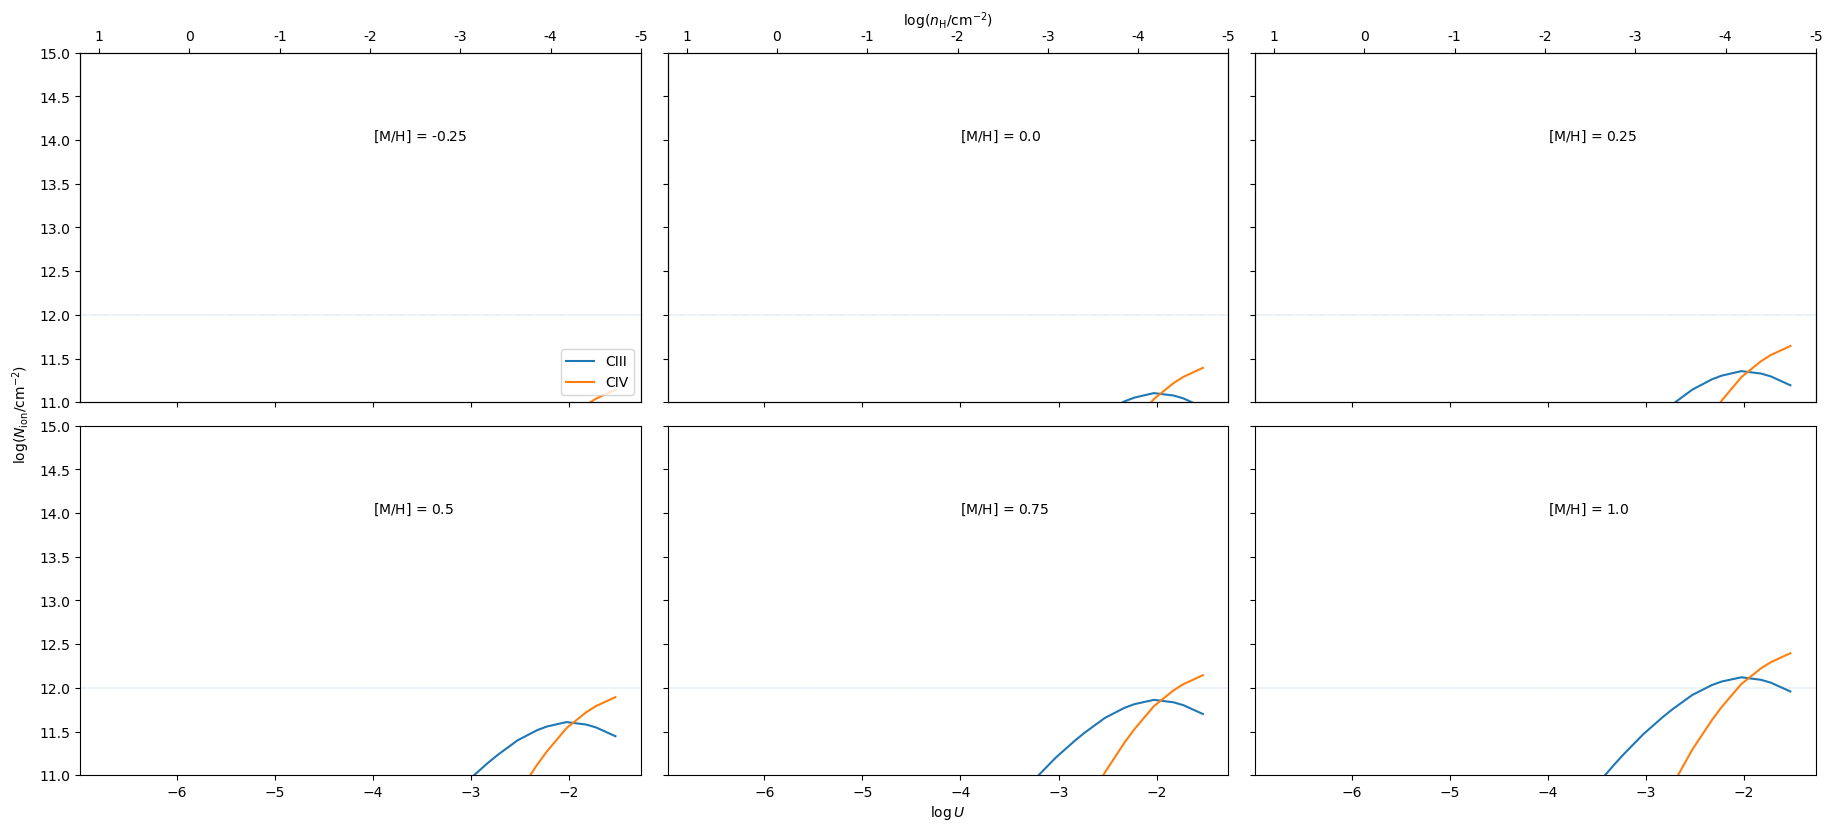

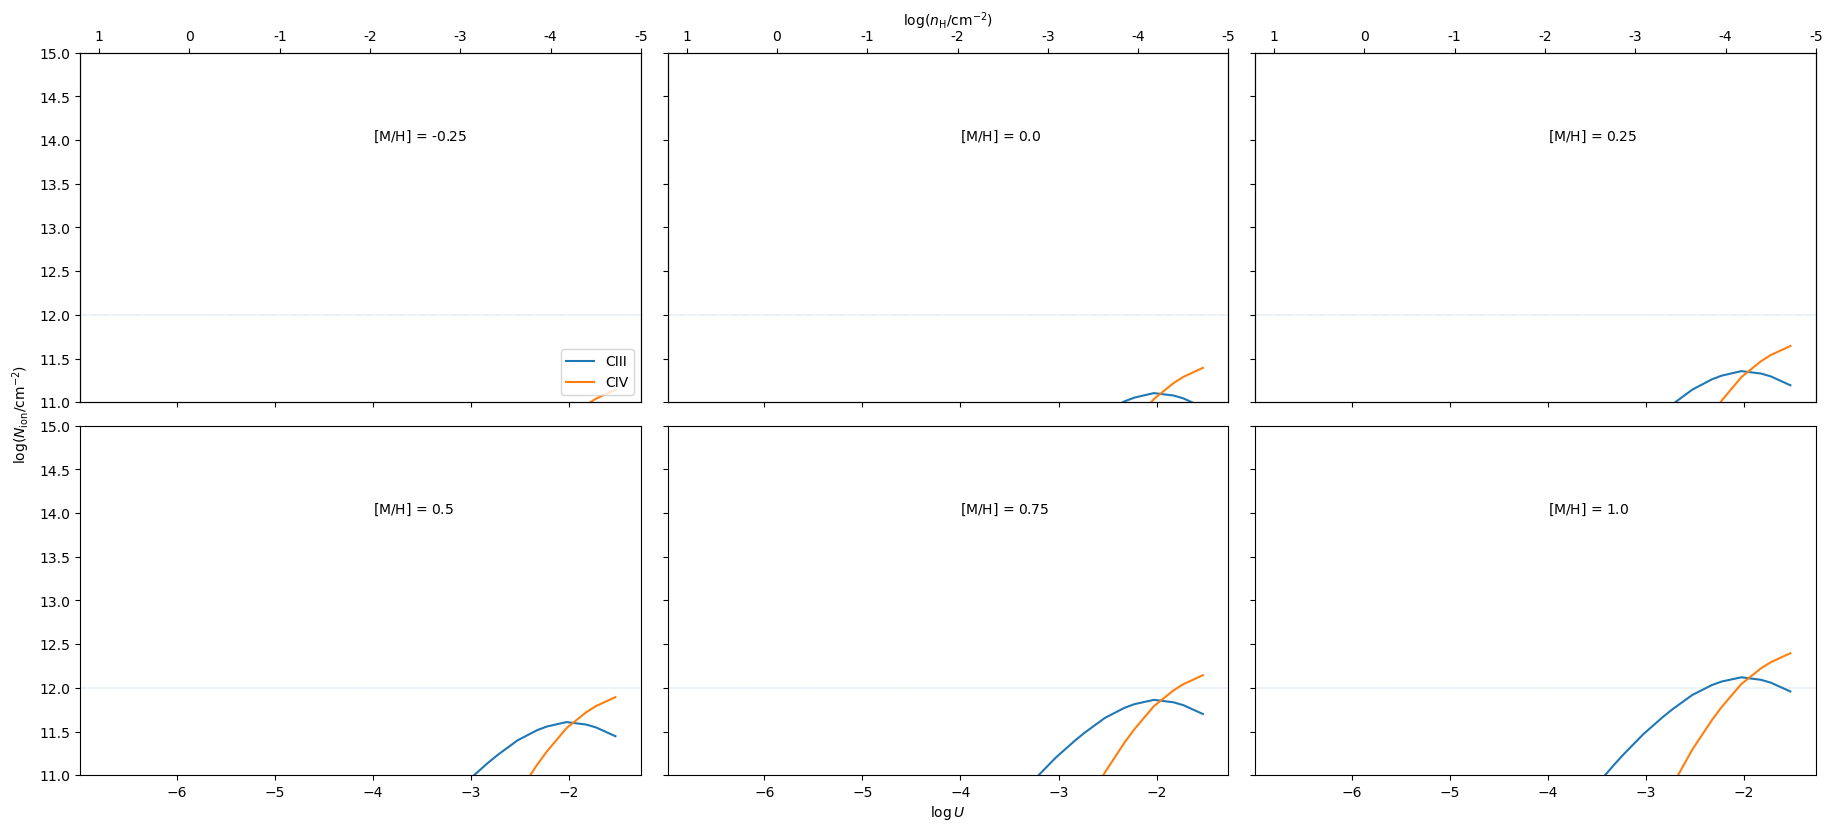

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(6*3,4*2), sharex=True, sharey=True)

for i in range(len(plot_log_metals)):
    
    log_m = plot_log_metals[i]
            
    ax = axes[i//3, i%3]
    
    ax.text(x=-4,y=14,s=r'$\mathrm{[M/H]}$ = ' + '{}'.format(log_m))
    
    # Reference line
    ax.axhline(logN_HI_test, linestyle=':', lw=.3)
    
    # Plotting points
    plot_points = [[logN_HI_test, log_hdens, log_m] for log_hdens in log_hdens_plot][:-1]
        
    # Plot interpolated column densities
    #ax.plot(logU_plot, species_logN_interp['#column density H'](plot_points), label='HI')
    ax.plot(logU_plot, species_logN_interp['C+2'](plot_points), label='CIII')
    ax.plot(logU_plot, species_logN_interp['C+3'](plot_points), label='CIV')
    #ax.plot(logU_plot, species_logN_interp['O+2'](plot_points), label='OIII')
    #ax.plot(logU_plot, species_logN_interp['O+3'](plot_points), label='OIV')
    #ax.plot(logU_plot, species_logN_interp['N+3'](plot_points), label='NIV')
    
    ax.set_ylim(2,17.5)

    if i//3 == 0:
        ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
        new_ticks = np.arange(-5,2,1, dtype='float')
        ax_copy.set_xlim(ax.get_xlim())
        ax_copy.set_xticks(np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, np.power(10, new_ticks))))
        ax_copy.set_xticklabels(np.int_(new_ticks))
    
    if i==0:
        ax.legend(loc='lower right')

plt.tight_layout()

#axes[0,0].set_xlim(-5, -2)
axes[0,0].set_ylim(11, 15)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel(r'$\log U$', labelpad=20)
ax_label.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^{-2})$', labelpad=35)

ax_copy_label = fig.add_subplot(111, frameon=False)
ax_copy_label.set_xticks([])
ax_copy_label.set_yticks([])
ax_copy_label.set_xlabel(r'$\log (n_\mathrm{H}/\mathrm{cm}^{-2})$', labelpad=20)
ax_copy_label.xaxis.set_label_position('top')
plt.show()

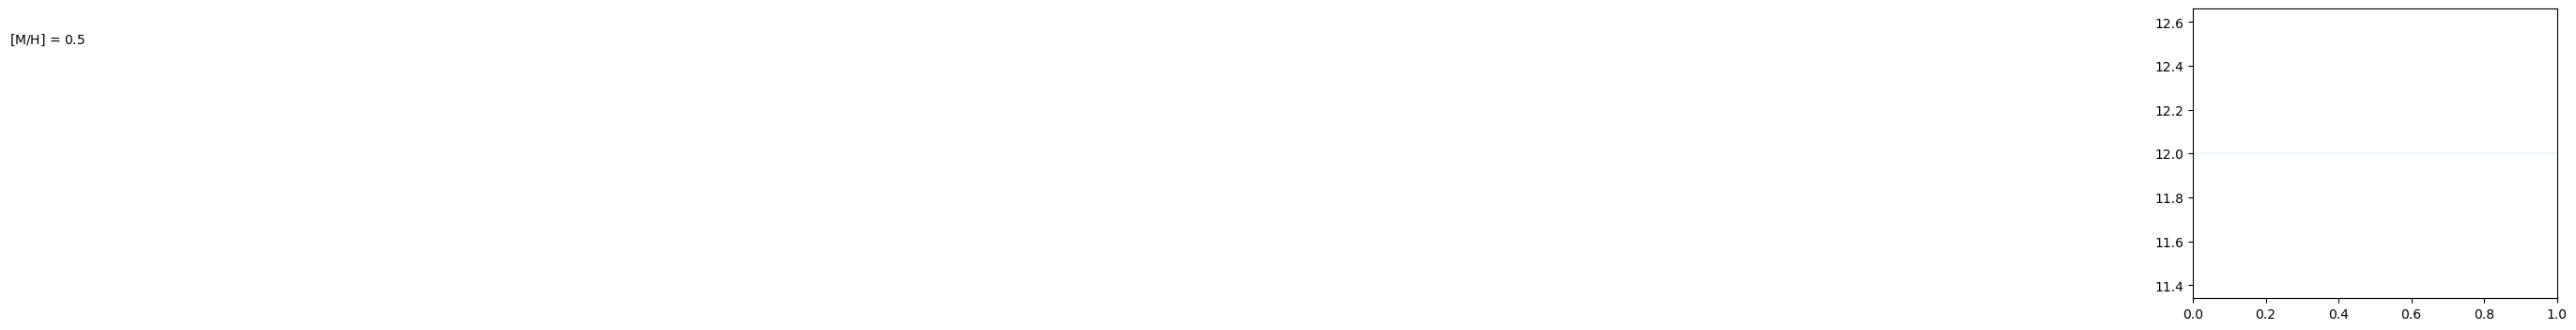

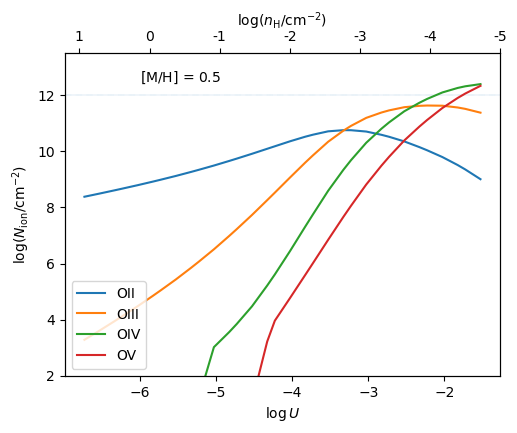

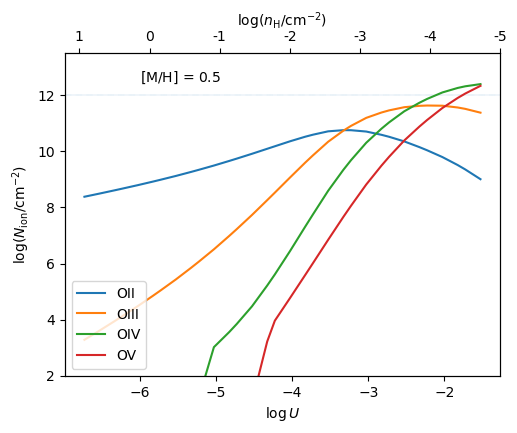

In [71]:
logN_HI_test = 12
log_metals_test = 0.5

fig, ax = plt.subplots(1, figsize=(5,4), sharex=True, sharey=True)

ax.text(x=-6,y=12.5,s=r'$\mathrm{[M/H]}$ = ' + '{}'.format(log_metals_test))

# Reference line
ax.axhline(logN_HI_test, linestyle=':', lw=.3)

# Plotting points
plot_points = [[logN_HI_test, log_hdens, log_metals_test] for log_hdens in log_hdens_plot][:-1]

# Plot interpolated column densities
ax.plot(logU_plot, species_logN_interp['O+'](plot_points), label='OII')
ax.plot(logU_plot, species_logN_interp['O+2'](plot_points), label='OIII')
ax.plot(logU_plot, species_logN_interp['O+3'](plot_points), label='OIV')
ax.plot(logU_plot, species_logN_interp['O+4'](plot_points), label='OV')

ax.set_ylim(2,13.5)

ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
new_ticks = np.arange(-5,2,1, dtype='float')
ax_copy.set_xlim(ax.get_xlim())
ax_copy.set_xticks(np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, np.power(10, new_ticks))))
ax_copy.set_xticklabels(np.int_(new_ticks))

ax.legend(loc='lower left')

plt.tight_layout()

ax.set_xlabel(r'$\log U$')
ax.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^{-2})$')

ax_copy_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_copy_label.set_xticks([])
ax_copy_label.set_yticks([])

ax_copy_label.set_xlabel(r'$\log (n_\mathrm{H}/\mathrm{cm}^{-2})$', labelpad=20)
ax_copy_label.xaxis.set_label_position('top')

plt.show()

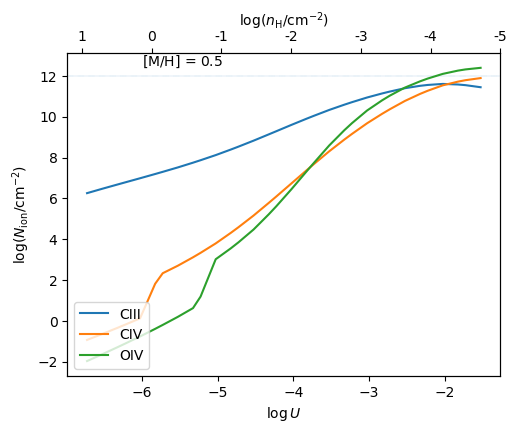

In [74]:
fig, ax = plt.subplots(1, figsize=(5,4), sharex=True, sharey=True)

ax.text(x=-6,y=12.5,s=r'$\mathrm{[M/H]}$ = ' + '{}'.format(log_metals_test))

# Reference line
ax.axhline(logN_HI_test, linestyle=':', lw=.3)

# Plotting points
plot_points = [[logN_HI_test, log_hdens, log_metals_test] for log_hdens in log_hdens_plot][:-1]

# Plot interpolated column densities
#ax.plot(logU_plot, species_logN_interp['O+'](plot_points), label='OII')
ax.plot(logU_plot, species_logN_interp['C+2'](plot_points), label='CIII')
ax.plot(logU_plot, species_logN_interp['C+3'](plot_points), label='CIV')
ax.plot(logU_plot, species_logN_interp['O+3'](plot_points), label='OIV')

# ax.set_ylim(11, 15)

ax_copy = ax.twiny() # https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis-in-matplotlib
new_ticks = np.arange(-5,2,1, dtype='float')
ax_copy.set_xlim(ax.get_xlim())
ax_copy.set_xticks(np.log10(calc_U(hm12_wav_grid, hm12_J_nu_test, np.power(10, new_ticks))))
ax_copy.set_xticklabels(np.int_(new_ticks))

ax.legend(loc='lower left')

plt.tight_layout()

ax.set_xlabel(r'$\log U$')
ax.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^{-2})$')

ax_copy_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_copy_label.set_xticks([])
ax_copy_label.set_yticks([])

ax_copy_label.set_xlabel(r'$\log (n_\mathrm{H}/\mathrm{cm}^{-2})$', labelpad=20)
ax_copy_label.xaxis.set_label_position('top')
plt.show()